In [2]:
import pandas as pd
folder = "signal_evolution_data/"


In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the data
folder = "signal_evolution_data/"  # Set your folder path
metadata = pd.read_pickle(folder + 'metadata.pkl')
noise_df_list = pd.read_pickle(folder + 'noise_dfs_over_time.pkl')
ws_df_list = pd.read_pickle(folder + 'weak_signal_dfs_over_time.pkl')
ss_df_list = pd.read_pickle(folder + 'strong_signal_dfs_over_time.pkl')


# Gather all the unique topic IDs and their representations from all dataframes at all timestamps
topic_representations = {}

# Assuming representation column name is 'Representation' in all dfs
for df_list in [noise_df_list, ws_df_list, ss_df_list]:
    for df in df_list:
        if not df.empty:
            for index, row in df.iterrows():
                topic_number = row['Topic']
                # Ensure topic_number is converted to string
                topic_number_str = str(topic_number)
                # Extract first three words from the representation
                first_three_words = '_'.join(row['Representation'].split('_')[:3])
                topic_representations[topic_number_str] = f"{topic_number_str}_{first_three_words}"

# Sort topics by their number
sorted_topic_representations = dict(sorted(topic_representations.items(), key=lambda item: int(item[0])))

# Select the first N topics
selected_topic_representations = dict(list(sorted_topic_representations.items()))

# Create a dataframe to store the signal strength for each topic at each timestamp
heatmap_data = []

# Iterate over the timestamps
for t in range(len(metadata['timestamps'])):
    ts = pd.to_datetime(metadata['timestamps'][t]).strftime('%Y-%m-%d')  # Format timestamp to 'YYYY MM DD'
    
    # Initialize the signal strength for each topic at the current timestamp
    signal_strength = {label: 0 for label in selected_topic_representations.values()}
    
    # Update the signal strength based on the presence of topics in each dataframe
    for topic, label in selected_topic_representations.items():
        if not noise_df_list[t].empty and int(topic) in noise_df_list[t]['Topic'].tolist():
            signal_strength[label] = 1
        elif not ws_df_list[t].empty and int(topic) in ws_df_list[t]['Topic'].tolist():
            signal_strength[label] = 2
        elif not ss_df_list[t].empty and int(topic) in ss_df_list[t]['Topic'].tolist():
            signal_strength[label] = 3
    
    # Append the signal strength for each topic at the current timestamp to the heatmap data
    heatmap_data.append({
        'Timestamp': ts,
        **signal_strength
    })

# Create a dataframe from the heatmap data
heatmap_df = pd.DataFrame(heatmap_data)
heatmap_df.reset_index(drop=True).set_index('Timestamp', inplace=True)

# Sort the heatmap dataframe by topic number
heatmap_df = heatmap_df[selected_topic_representations.values()]



In [4]:
import os
import pandas as pd
import plotly.graph_objects as go

THRESHOLD=0.7

# Create the heatmap with Plotly
fig = go.Figure(data=go.Heatmap(
    z=heatmap_df.T.values,
    x=heatmap_df.index,
    y=heatmap_df.columns,
    colorscale='Blues',
    zmin=0,
    zmax=3,
    colorbar=dict(
        title='Signal Strength',
        tickvals=[0, 1, 2, 3],
        ticktext=['0', '1', '2', '3']
    )
))

fig.update_layout(
    title='Topic Signal Strength Heatmap',
    xaxis=dict(title='Timestamp', tickangle=-45),
    yaxis=dict(title='Topic'),
    font=dict(size=12),
    width=2000,  # Adjust the width as needed
    height=2000   # Adjust the height as needed
)

# Add metadata information to the figure
granularity = metadata.get('granularity', 'default_granularity')
window_size = metadata.get('window_size', 'default_window_size')
metadata_text = f"Granularity: {granularity}, Window Size: {window_size}, Merge: {THRESHOLD}"
fig.add_annotation(
    x=0.5,
    y=-0.15,
    text=metadata_text,
    showarrow=False,
    font=dict(size=14),
    xref='paper',
    yref='paper'
)

# Create directories if they don't exist
directory = f"Figures/Arxiv_17_21_100k/Heatmaps/"
os.makedirs(directory, exist_ok=True)

# Save the figure
filename = f"granularity_{granularity}_ws_{window_size}_threshold_{THRESHOLD}.html"
file_path = os.path.join(directory, filename)
fig.write_html(file_path)

fig.show()

In [5]:
import os
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime, timedelta
import re 

# Load the data
folder = "signal_evolution_data/"  # Set your folder path
metadata = pd.read_pickle(folder + 'metadata.pkl')
noise_df_list = pd.read_pickle(folder + 'noise_dfs_over_time.pkl')
ws_df_list = pd.read_pickle(folder + 'weak_signal_dfs_over_time.pkl')
ss_df_list = pd.read_pickle(folder + 'strong_signal_dfs_over_time.pkl')

In [9]:
# Gather all the unique topic IDs and their representations from all dataframes at all timestamps
topic_representations = {}

# Assuming representation column name is 'Representation' in all dfs
for df_list in [noise_df_list, ws_df_list, ss_df_list]:
    for df in df_list:
        if not df.empty:
            for index, row in df.iterrows():
                topic_number = row['Topic']
                # Ensure topic_number is converted to string
                topic_number_str = str(topic_number)
                # Extract first three words from the representation
                words = '_'.join(row['Representation'].split('_'))
                topic_representations[topic_number_str] = f"{topic_number_str}_{words}"

# Sort topics by their number
sorted_topic_representations = dict(sorted(topic_representations.items(), key=lambda item: int(item[0])))

# Extract representations for each topic
topic_representations_full = {}
for df_list in [noise_df_list, ws_df_list, ss_df_list]:
    for df in df_list:
        if not df.empty:
            for topic in df['Topic'].unique():
                if str(topic) not in topic_representations_full:
                    topic_representations_full[str(topic)] = df[df['Topic'] == topic]['Representations'].values[0]

# Function to parse representations and create a mapping of timestamp to representation
def parse_representations(representations):
    timestamp_representation_map = {}
    for entry in representations:
        timestamp, representation = entry.split(': ', 1)
        timestamp_representation_map[pd.to_datetime(timestamp).strftime('%Y-%m-%d')] = representation
    return timestamp_representation_map


# Search functionality
search_keywords = input("Enter search keywords (comma-separated): ").split(',')
search_keywords = [keyword.strip().lower() for keyword in search_keywords]

# Filter topics based on search keywords
filtered_topic_representations = {topic: representation for topic, representation in sorted_topic_representations.items()
                                  if any(keyword in representation.lower() for keyword in search_keywords)}

# Create figures for each matching topic and aggregate data
figures = []
aggregated_popularity = [0] * len(metadata['timestamps'])
aggregated_heatmap = [0] * len(metadata['timestamps'])
aggregated_hover_info = [[] for _ in range(len(metadata['timestamps']))]

for topic, representation in filtered_topic_representations.items():
    # Create a dataframe to store the signal strength for each topic at each timestamp
    heatmap_data = []
    popularity_data = []

    # Get full representation for the topic
    full_representation = topic_representations_full[topic]
    timestamp_representation_map = parse_representations(full_representation)
    print(timestamp_representation_map)
    # Iterate over the timestamps
    for t in range(len(metadata['timestamps'])):

        ts = (pd.to_datetime(metadata['timestamps'][t])).strftime('%Y-%m-%d')
        
        # Initialize the signal strength for the topic at the current timestamp
        signal_strength = 0
        
        # Update the signal strength based on the presence of the topic in each dataframe
        if not noise_df_list[t].empty and int(topic) in noise_df_list[t]['Topic'].tolist():
            signal_strength = 1
            popularity = noise_df_list[t].loc[noise_df_list[t]['Topic'] == int(topic), 'Latest Popularity'].values[0]
        elif not ws_df_list[t].empty and int(topic) in ws_df_list[t]['Topic'].tolist():
            signal_strength = 2
            popularity = ws_df_list[t].loc[ws_df_list[t]['Topic'] == int(topic), 'Latest Popularity'].values[0]
        elif not ss_df_list[t].empty and int(topic) in ss_df_list[t]['Topic'].tolist():
            signal_strength = 3
            popularity = ss_df_list[t].loc[ss_df_list[t]['Topic'] == int(topic), 'Latest Popularity'].values[0]
        else:
            popularity = 0
        
        # Append the signal strength for the topic at the current timestamp to the heatmap data
        heatmap_data.append(signal_strength)
        
        # Append the popularity for the topic at the current timestamp to the popularity data
        popularity_data.append(popularity)
        
        # Add to aggregated popularity
        aggregated_popularity[t] += popularity

        # Update the aggregated heatmap with the maximum signal strength
        aggregated_heatmap[t] = max(aggregated_heatmap[t], signal_strength)

        # Add representation to aggregated hover info
        aggregated_hover_info[t].append(timestamp_representation_map.get(ts, "No data"))

    # Create subplots for heatmap and popularity plot
    fig = make_subplots(rows=2, cols=1, row_heights=[0.3, 0.7], vertical_spacing=0.1,
                        subplot_titles=[f"Signal Category for {representation}", f"Popularity Evolution"])

    # Add heatmap trace
    fig.add_trace(go.Heatmap(
        z=[heatmap_data],
        x=metadata['timestamps'],
        y=[representation],
        colorscale=[[0, 'black'], [0.33, 'blue'], [0.66, 'orange'], [1, 'red']],
        zmin=0,
        zmax=3,
        showscale=False,
        hovertemplate='Timestamp: %{x}<br>Signal Strength: %{z}<br>Representation: %{customdata}<extra></extra>',
        customdata=[[timestamp_representation_map.get((pd.to_datetime(t)).strftime('%Y-%m-%d'), "No data") for t in metadata['timestamps']]]  # Use the adjusted timestamp for hover data
    ), row=1, col=1)

    # Add popularity plot trace
    fig.add_trace(go.Scatter(
        x=metadata['timestamps'],
        y=popularity_data,
        mode='lines',
        name=representation,
        hovertemplate='Timestamp: %{x}<br>Popularity: %{y}<br>Representation: %{customdata}<extra></extra>',
        customdata=[timestamp_representation_map.get((pd.to_datetime(t)).strftime('%Y-%m-%d'), "No data") for t in metadata['timestamps']]  # Use the adjusted timestamp for hover data
    ), row=2, col=1)

    # Update layout
    fig.update_layout(
        height=600,
    )

    # Update axis properties
    fig.update_xaxes(title_text='Timestamp', row=1, col=1)
    fig.update_yaxes(showticklabels=False, row=1, col=1)
    fig.update_xaxes(title_text='Timestamp', row=2, col=1)
    fig.update_yaxes(title_text='Signal Strength', row=1, col=1)
    fig.update_yaxes(title_text='Popularity', row=2, col=1)

    figures.append(fig)

# Create aggregated figure combining popularity and heatmap
agg_fig = make_subplots(rows=2, cols=1, row_heights=[0.5, 0.5], vertical_spacing=0.1,
                        subplot_titles=["Aggregated Signal Strength Over Time"])

# Filter representations to include only those that contain at least one word from the search query
filtered_hover_info = [
    [rep for rep in reps]
    for reps in aggregated_hover_info
]

# Format customdata with line breaks
formatted_hover_info = [['<br>'.join([rep for rep in reps if rep != "No data"]) for reps in filtered_hover_info]]

# Add aggregated heatmap trace
agg_fig.add_trace(go.Heatmap(
    z=[aggregated_heatmap],
    x=metadata['timestamps'],
    y=["Aggregated Signal Strength"],
    colorscale=[[0, 'rgba(0, 0, 0, 0)'], [0.33, 'blue'], [0.66, 'orange'], [1, 'red']],
    zmin=0,
    zmax=3,
    showscale=True,
    hovertemplate='Timestamp: %{x}<br>Signal Strength: %{z}<br>Representations: %{customdata}<extra></extra>',
    customdata=formatted_hover_info
), row=1, col=1)

# Format customdata with line breaks for the scatter plot
formatted_hover_info_scatter = ['<br>'.join([rep for rep in reps if rep != "No data"]) for reps in filtered_hover_info]

# Add aggregated popularity plot trace
agg_fig.add_trace(go.Scatter(
    x=metadata['timestamps'],
    y=aggregated_popularity,
    mode='lines',
    name='Aggregated Popularity',
    hovertemplate='Timestamp: %{x}<br>Aggregated Popularity: %{y}<br>Representations:<br>%{customdata}<extra></extra>',
    customdata=formatted_hover_info_scatter
), row=2, col=1)

agg_fig.update_layout(
    height=800,
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

agg_fig.update_xaxes(title_text='Timestamp', row=1, col=1, matches='x')
agg_fig.update_xaxes(title_text='Timestamp', row=2, col=1, matches='x')

agg_fig.update_yaxes(title_text='Signal Strength', row=1, col=1)
agg_fig.update_yaxes(title_text='Popularity', row=2, col=1)


# Insert aggregated figure at the beginning
figures.insert(0, agg_fig)

# Create navigation buttons
current_index = 0

# Create navigation buttons
current_index = 0

def show_figure(index):
    clear_output(wait=True)
    display(figures[index])
    display(prev_button, next_button)

def on_next_button_clicked(b):
    global current_index
    if current_index < len(figures) - 1:
        current_index += 1
    show_figure(current_index)

def on_prev_button_clicked(b):
    global current_index
    if current_index > 0:
        current_index -= 1
    show_figure(current_index)

next_button = widgets.Button(description="Next")
prev_button = widgets.Button(description="Previous")

next_button.on_click(on_next_button_clicked)
prev_button.on_click(on_prev_button_clicked)

# Display initial figure and buttons
show_figure(current_index)


Button(description='Previous', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

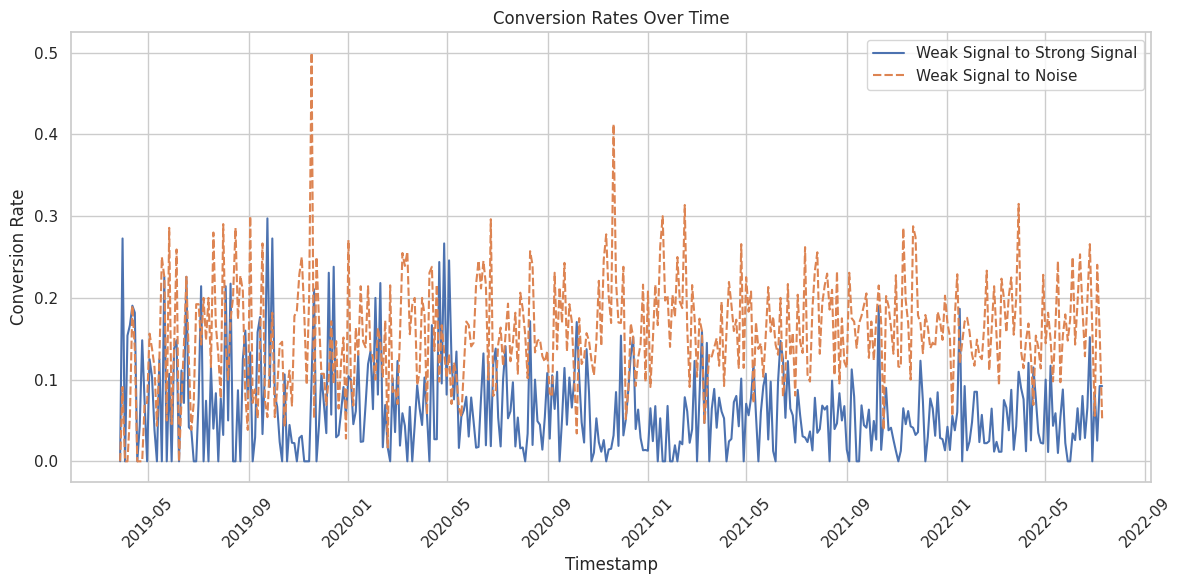

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the data is already loaded and conversion_df is created as per your code above

# Format the Timestamps to only include the date in 'YYYY-MM-DD' format
conversion_df.index = pd.to_datetime(conversion_df.index).date

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=conversion_df)
plt.title('Conversion Rates Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust subplots to give some padding

plt.show()


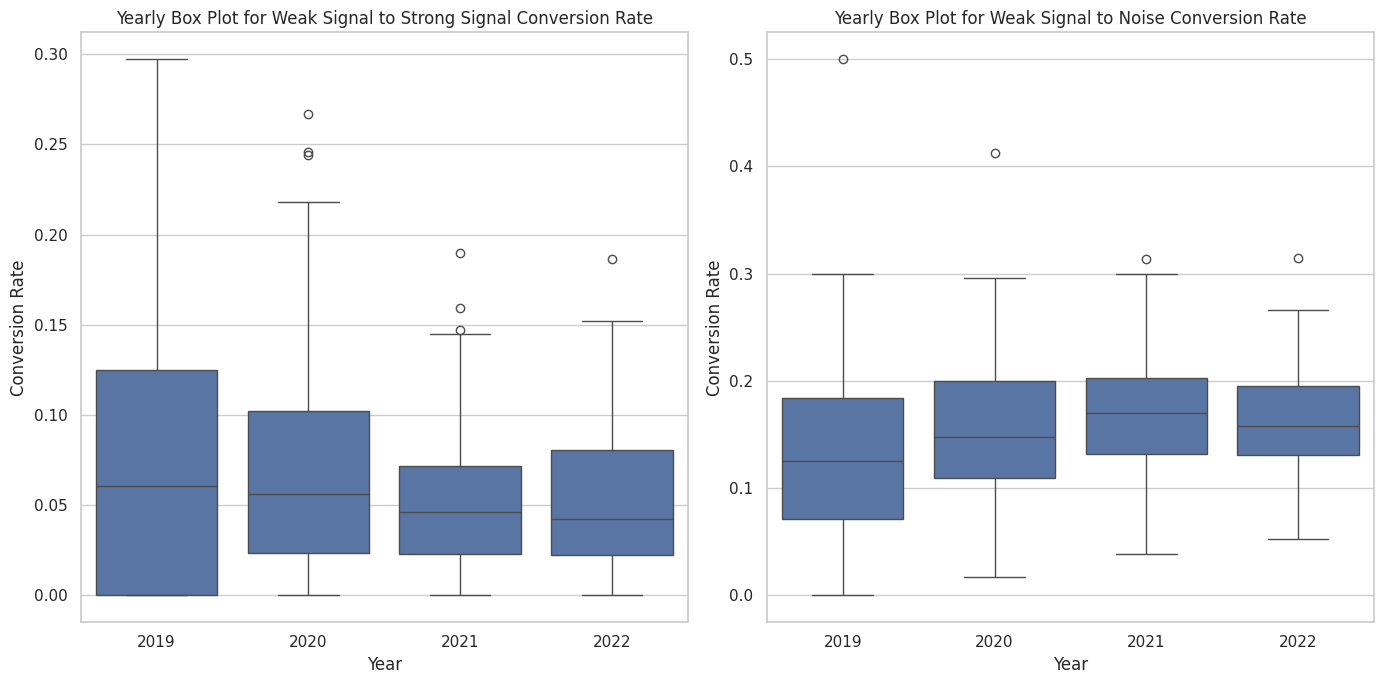

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming conversion_df is already defined and loaded with your previous data

# Convert index to datetime if it isn't already
conversion_df.index = pd.to_datetime(conversion_df.index)

# Extract year from each timestamp and add it as a new column
conversion_df['Year'] = conversion_df.index.year

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Initialize a matplotlib figure with a certain size
plt.figure(figsize=(14, 7))

# Create a box plot for 'Weak Signal to Strong Signal'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.boxplot(x='Year', y='Weak Signal to Strong Signal', data=conversion_df.reset_index())
plt.title('Yearly Box Plot for Weak Signal to Strong Signal Conversion Rate')
plt.xlabel('Year')
plt.ylabel('Conversion Rate')

# Create a box plot for 'Weak Signal to Noise'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.boxplot(x='Year', y='Weak Signal to Noise', data=conversion_df.reset_index())
plt.title('Yearly Box Plot for Weak Signal to Noise Conversion Rate')
plt.xlabel('Year')
plt.ylabel('Conversion Rate')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()
